# Librerías

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from limpieza import *
time.sleep(0.5)

In [3]:
#!pip install ipython-autotime
%load_ext autotime

In [29]:
data = 'D:/Descargas/datos_gps_curso_ciencia_de_datos/gps_filtered.csv'
processed_path = 'D:/Descargas/datos_gps_curso_ciencia_de_datos/gps_processed.csv'
train_path = 'D:/Descargas/datos_gps_curso_ciencia_de_datos/train.csv'
val_path = 'D:/Descargas/datos_gps_curso_ciencia_de_datos/val.csv'
test_path = 'D:/Descargas/datos_gps_curso_ciencia_de_datos/test.csv'
mean_path = 'mean.csv'
std_path = 'std.csv'
test_days = [28, 29, 30, 31]
train_val_perc = 0.2

delta_exp = 200     # Cantidad en metros de split de nueva expedicion
epsilon_exp = 10    # Cantidad en metros para filtrar no movimiento
maxRoute = 500      # Cantidad en metros maxima de la distancia a la ruta

max_dif = 3600      # Maxima diferencia de tiempo aceptada
thresh = 50         # Minima cantidad de pulsos en una expedicion para ser considerada
delta_dist = 50    # Distancia en metros minima entre dos pulsos para ser pareados
n = 10              # Multiplicador de cantidad de pulsos pares maximos, n igual a 1 los pares de pulsos son igual a la cantida de pulsos
jump = 2            # Cantidad de indices que se salta al realizar pares de pulsos
gain = 50            # Aumento de distancia minima a medida que la diferencia de indices aumenta

time: 2 ms


# Lectura base de datos

In [5]:
gps = pd.read_csv(data, sep=",")
gps.head()

,Unnamed: 0,DistanciaInicio,DistanciaRuta,GPS_time,Ind1,Ind2,Ind3,Latitud,Longitud,Patente,Servicio,Unnamed: 0.1,Unnamed: 0.1.1
0,0,0,147,2019-08-01 00:00:28,0,5,0,-33.543559,-70.789180,BDXR-15,T506 00I,0,12057.0
1,1,0,140,2019-08-01 00:00:15,0,5,0,-33.543655,-70.788752,BFKB-85,T506 00I,1,12058.0
2,2,0,140,2019-08-01 00:00:45,0,5,0,-33.543655,-70.788752,BFKB-85,T506 00I,2,12059.0
3,3,0,140,2019-08-01 00:01:15,0,5,0,-33.543655,-70.788752,BFKB-85,T506 00I,3,12060.0
4,4,0,139,2019-08-01 00:01:45,5,5,0,-33.543637,-70.788783,BFKB-85,T506 00I,4,12061.0


time: 35.9 s


# Limpieza de base de datos

In [6]:
gps = limpieza(gps)

time: 3min 30s


In [7]:
gps.head()

,Unnamed: 0,DistanciaInicio,DistanciaRuta,GPS_time,Ind1,Ind2,Ind3,Latitud,Longitud,Patente,Servicio,Unnamed: 0.1,Unnamed: 0.1.1,dia_habil,dia_Monday,dia_Saturday,dia_Sunday,dia_Thursday,dia_Tuesday,dia_Wednesday
0,0,0,147,2019-08-01 00:00:28,0,5,0,-33.543559,-70.789180,BDXR-15,T506 00I,0,12057.0,1,0,0,0,1,0,0
1,1,0,140,2019-08-01 00:00:15,0,5,0,-33.543655,-70.788752,BFKB-85,T506 00I,1,12058.0,1,0,0,0,1,0,0
2,2,0,140,2019-08-01 00:00:45,0,5,0,-33.543655,-70.788752,BFKB-85,T506 00I,2,12059.0,1,0,0,0,1,0,0
3,3,0,140,2019-08-01 00:01:15,0,5,0,-33.543655,-70.788752,BFKB-85,T506 00I,3,12060.0,1,0,0,0,1,0,0
4,4,0,139,2019-08-01 00:01:45,5,5,0,-33.543637,-70.788783,BFKB-85,T506 00I,4,12061.0,1,0,0,0,1,0,0


time: 19 ms


In [12]:
# Se filtran pulsos con distancia a la ruta muy grande
gps = gps[gps["DistanciaRuta"] < maxRoute]

time: 1.86 s


# Separación de expediciones

In [14]:
gps["GPS_time"] = pd.to_datetime(gps["GPS_time"])
gps = gps.sort_values(by=['GPS_time'])

time: 3.2 s


In [15]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
time: 4 ms


In [16]:
%%cython
import cython
import numpy as np
cimport numpy as np

"""
cpdef float [:] expeditions(float [:, :] gps, float delta, float epsilon):
    cdef np.ndarray[np.float32_t, ndim=1] output = np.zeros((gps.shape[0]), dtype=np.float32)
    cdef int i
    cdef int n_exp = 0

    for i in range(gps.shape[0] - 1):
        output[i] = n_exp
        if np.abs(gps[i+1, 0] - gps[i, 0]) + np.abs(gps[i+1, 1] - gps[i, 1]) <= epsilon:
            output[i] = -1
        elif np.abs(gps[i+1, 0] - gps[i, 0]) > delta:
            n_exp += 1
    output[-1] = n_exp
    
    return output
"""
cpdef float [:] expeditions(float [:, :] gps, float delta, float epsilon):
    cdef np.ndarray[np.float32_t, ndim=1] output = np.zeros((gps.shape[0]), dtype=np.float32)
    cdef int i
    cdef int n_exp = 0

    for i in range(gps.shape[0] - 1):
        output[i] = n_exp
        # Filtra pulsos que estan muy cerca
        if np.abs(gps[i+1, 0] - gps[i, 0]) + np.abs(gps[i+1, 1] - gps[i, 1]) <= epsilon:
            output[i] = -1
        # Nueva expedicion cuando la diferencia en distancia desde el inicio es negativa y menor que un valor
        elif gps[i+1, 0] - gps[i, 0] < -delta:
            n_exp += 1
    output[-1] = n_exp
    
    return output

time: 9 ms


In [17]:
def get_expeditions(gps, delta, epsilon=-1):
    aux = gps.sort_values(by=['GPS_time'])[["DistanciaInicio", "DistanciaRuta"]].to_numpy(dtype=np.float32)
    expedition = np.asarray(expeditions(aux, delta, epsilon))
    return expedition

time: 1 ms


In [18]:
def add_expedition(gps, delta, epsilon=0):
    servicios = gps["Servicio"].unique()
    total = len(servicios)
    for idy, servicio in enumerate(servicios):
        print('Servicio {}/{}'.format(idy+1, total))
        gps_servicio = gps[gps["Servicio"] == servicio]
        patentes = gps_servicio["Patente"].unique()
        total_pat = len(patentes)
        for idx, patente in enumerate(patentes):
            print('\rPatente {}/{}'.format(idx+1, total_pat), end='')
            gps_patente = gps_servicio[gps_servicio["Patente"] == patente].sort_values(by=['GPS_time'])
            exp_max = np.max(gps_patente["DistanciaInicio"])
            gps_patente["Expedicion"] = get_expeditions(gps_patente, delta, epsilon).astype(int)
            gps_patente = gps_patente[gps_patente["Expedicion"] >= 0]
            gps_patente["exp_id"] = gps_patente["Patente"] + "_" + gps_patente["Expedicion"].astype(str)
            gps_patente = gps_patente.drop(columns=["Patente", "Expedicion"])
            if idx == 0 and idy == 0:
                nuevo_gps = gps_patente.to_numpy()
                headers = list(gps_patente.columns)
            else:
                nuevo_gps = np.concatenate((nuevo_gps, gps_patente.to_numpy()), axis=0)
        print('\n')
    return pd.DataFrame(nuevo_gps, columns=headers)

time: 4 ms


In [19]:
gps = add_expedition(gps, delta_exp, epsilon=epsilon_exp)
gps

Servicio 1/19
Patente 236/236

Servicio 2/19
Patente 268/268

Servicio 3/19
Patente 272/272

Servicio 4/19
Patente 270/270

Servicio 5/19
Patente 133/133

Servicio 6/19
Patente 197/197

Servicio 7/19
Patente 245/245

Servicio 8/19
Patente 202/202

Servicio 9/19
Patente 235/235

Servicio 10/19
Patente 140/140

Servicio 11/19
Patente 258/258

Servicio 12/19
Patente 293/293

Servicio 13/19
Patente 199/199

Servicio 14/19
Patente 201/201

Servicio 15/19
Patente 353/353

Servicio 16/19
Patente 230/230

Servicio 17/19
Patente 301/301

Servicio 18/19
Patente 237/237

Servicio 19/19
Patente 346/346



,Unnamed: 0,DistanciaInicio,DistanciaRuta,GPS_time,Ind1,Ind2,Ind3,Latitud,Longitud,Servicio,Unnamed: 0.1,Unnamed: 0.1.1,dia_habil,dia_Monday,dia_Saturday,dia_Sunday,dia_Thursday,dia_Tuesday,dia_Wednesday,exp_id
0,182891,29940,0,2019-08-01 00:00:00,26,4,0,-33.4091,-70.5682,T421 00I,182891,9492,1,0,0,0,1,0,0,ZN-5344_0
1,182892,30011,4,2019-08-01 00:00:30,8,4,0,-33.4089,-70.5675,T421 00I,182892,9493,1,0,0,0,1,0,0,ZN-5344_0
2,182893,30362,6,2019-08-01 00:01:00,58,4,0,-33.4079,-70.5639,T421 00I,182893,9494,1,0,0,0,1,0,0,ZN-5344_0
3,182894,30787,1,2019-08-01 00:01:30,48,4,0,-33.4076,-70.5594,T421 00I,182894,9495,1,0,0,0,1,0,0,ZN-5344_0
4,182924,31105,0,2019-08-01 00:02:00,0,4,4,-33.408,-70.556,T421 00I,182924,23455,1,0,0,0,1,0,0,ZN-5344_0
5,182925,31297,0,2019-08-01 00:02:30,53,4,4,-33.4083,-70.5539,T421 00I,182925,23456,1,0,0,0,1,0,0,ZN-5344_0
6,182926,31750,2,2019-08-01 00:03:00,56,4,0,-33.4082,-70.5491,T421 00I,182926,23457,1,0,0,0,1,0,0,ZN-5344_0
7,182927,32079,5,2019-08-01 00:03:30,13,4,0,-33.408,-70.5456,T421 00I,182927,23458,1,0,0,0,1,0,0,ZN-5344_0
8,182956,32307,7,2019-08-01 00:04:00,35,4,0,-33.4065,-70.5442,T421 00I,182956,37237,1,0,0,0,1,0,0,ZN-5344_0
9,182957,32682,0,2019-08-01 00:04:30,40,4,0,-33.4055,-70.5404,T421 00I,182957,37238,1,0,0,0,1,0,0,ZN-5344_0


time: 2h 43min 50s


In [20]:
gps.to_csv('D:/Descargas/datos_gps_curso_ciencia_de_datos/checkpoint.csv', sep=',', index=False, mode='w+')

time: 2min 8s


# Pares de pulsos

In [5]:
gps = pd.read_csv('D:/Descargas/datos_gps_curso_ciencia_de_datos/checkpoint.csv', sep=',')
gps["GPS_time"] = pd.to_datetime(gps["GPS_time"])
gps.head()

,Unnamed: 0,DistanciaInicio,DistanciaRuta,GPS_time,Ind1,Ind2,Ind3,Latitud,Longitud,Servicio,Unnamed: 0.1,Unnamed: 0.1.1,dia_habil,dia_Monday,dia_Saturday,dia_Sunday,dia_Thursday,dia_Tuesday,dia_Wednesday,exp_id
0,182891,29940,0,2019-08-01 00:00:00,26,4,0,-33.409089,-70.568177,T421 00I,182891,9492.0,1,0,0,0,1,0,0,ZN-5344_0
1,182892,30011,4,2019-08-01 00:00:30,8,4,0,-33.408872,-70.567463,T421 00I,182892,9493.0,1,0,0,0,1,0,0,ZN-5344_0
2,182893,30362,6,2019-08-01 00:01:00,58,4,0,-33.407944,-70.563855,T421 00I,182893,9494.0,1,0,0,0,1,0,0,ZN-5344_0
3,182894,30787,1,2019-08-01 00:01:30,48,4,0,-33.407622,-70.559355,T421 00I,182894,9495.0,1,0,0,0,1,0,0,ZN-5344_0
4,182924,31105,0,2019-08-01 00:02:00,0,4,4,-33.407989,-70.555974,T421 00I,182924,23455.0,1,0,0,0,1,0,0,ZN-5344_0


time: 43.8 s


In [6]:
# Se eliminan expediciones con menos de cirta cantidad de pulsos
expeditions_count = gps.groupby('exp_id').size().reset_index(name='count')
exp_list = expeditions_count[expeditions_count["count"] > thresh]["exp_id"]
gps = gps[gps["exp_id"].isin(exp_list)]

time: 2.17 s


In [7]:
%load_ext Cython

time: 584 ms


In [8]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float [:, :] pair_gps(float [:, :] expedition, float delta, int quant, int jump=1, float gain=0):
    cdef np.ndarray[np.float32_t, ndim=2] output = -np.ones([expedition.shape[0]*quant, 2], dtype = np.float32)
    cdef int i, j
    cdef int l = 0
    cdef int from_init_col = 0
    cdef int to_rout_col = 1
    cdef float dif_dist1, dif_dist2
    cdef float last_inrout, last_torout
    cdef float delta_gain = delta
    for i in range(0, expedition.shape[0], jump):
        if l >= expedition.shape[0]*quant:
            break
        last_inrout = expedition[i, from_init_col]
        last_torout = expedition[i, to_rout_col]
        for j in range(i + 1, expedition.shape[0]):
            delta_gain = delta + gain * (j - i - 1)
            if l >= expedition.shape[0]*quant:
                break
            dif_dist1 = np.abs(last_inrout - expedition[j, from_init_col])
            dif_dist2 = np.abs(last_torout - expedition[j, to_rout_col])
            if dif_dist1 + dif_dist2 > delta_gain:
                output[l, 0] = i
                output[l, 1] = j
                l += 1
                last_inrout = expedition[j, from_init_col]
                last_torout = expedition[j, to_rout_col]
    return output

time: 11 ms


In [21]:
def pair(expedition, delta, quant, jump, gain=0, max_dif=1e10):
    expedition = expedition.sort_values(by=['GPS_time'])
    distances = expedition[["DistanciaInicio", "DistanciaRuta"]].to_numpy(dtype=np.float32)
    indexes = np.asarray(pair_gps(distances, delta, quant, jump=jump, gain=gain))
    indexes = indexes[indexes[:, 0] >= 0]
    if indexes.shape[0] > 0:
        gps1 = expedition.iloc[indexes[:, 0], :].add_suffix('1').reset_index()
        gps2 = expedition.iloc[indexes[:, 1], :].add_suffix('2').reset_index()
        concatenated_gps = pd.concat([gps1, gps2], axis=1).drop(columns=["exp_id1"]).rename(columns={'exp_id2': 'exp_id', 'Servicio2': 'Servicio'})
        concatenated_gps["Diferencia"] = (concatenated_gps["GPS_time2"] - concatenated_gps["GPS_time1"]).dt.total_seconds()
        concatenated_gps = concatenated_gps.drop(columns=["index", "GPS_time1", "GPS_time2", "Servicio1"])
        return concatenated_gps[concatenated_gps["Diferencia"] < max_dif]
    else:
        return None

time: 2.96 ms


In [22]:
def pair_every_gps(gps, delta, quant, jump, gain=0, max_dif=1e10):
    servicios = gps["Servicio"].unique()
    output = []
    total = len(servicios)
    for idx, servicio in enumerate(servicios):
        print('Servicio {}/{}'.format(idx+1, total))
        gps_servicio = gps[gps["Servicio"] == servicio]
        expeditions = gps_servicio["exp_id"].unique()
        total_exp = len(expeditions)
        for j, expedition in enumerate(expeditions):
            print('\rExpedicion {}/{}'.format(j+1, total_exp), end='')
            gps_expedition = gps_servicio[gps_servicio["exp_id"] == expedition]
            pairs = pair(gps_expedition, delta, quant, jump, max_dif=max_dif, gain=gain)
            if not pairs is None:
                output.append(pairs)
        print('\n')
    if len(output) == 0:
        return None
    return pd.concat(output, axis=0, ignore_index=True)

time: 2 ms


In [23]:
def pair_gps_day(gps, delta, quant, jump, file_path, max_dif=1e10, start=0, gain=0):
    dates = gps["GPS_time"].map(pd.Timestamp.date).unique()
    total_dates = len(dates)
    for idx, d in enumerate(dates):
        if idx >= start:
            print("Fecha numero: {}/{}".format(idx+1, total_dates))
            gps_date = gps[gps["GPS_time"].dt.date == d]
            paired_gps = pair_every_gps(gps_date, thresh, n, jump, max_dif=max_dif, gain=gain)
            if paired_gps is not None:
                paired_gps = paired_gps.drop(columns=["Unnamed: 01", "Ind11", "Ind21", "Ind31", "Unnamed: 0.11", "Unnamed: 0.1.11", "Unnamed: 02", "Ind12", "Ind22", "Ind32", "Unnamed: 0.12", "Unnamed: 0.1.12", "dia_habil2", "dia_Monday2", "dia_Saturday2", "dia_Sunday2", "dia_Thursday2", "dia_Tuesday2", "dia_Wednesday2"])
                header = idx == start
                paired_gps.to_csv(file_path, sep=',', index=False, mode='a+', header=header)
    print("Done :)")

time: 2 ms


Text(0.5, 1.0, 'Cantidad de pares por diferencia de tiempo (minutos)')

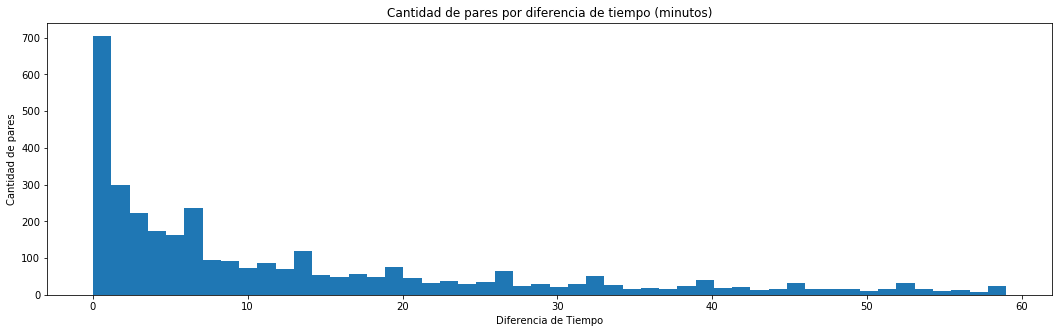

time: 2.2 s


In [30]:
gps_exped = gps[gps["exp_id"] == gps["exp_id"].unique()[0]]
paired_gps = pair(gps_exped, delta_dist, n, jump, gain=gain, max_dif=max_dif)
plt.figure(figsize=(18, 5))
_ = plt.hist(paired_gps['Diferencia']//60, bins=50)
plt.xlabel("Diferencia de Tiempo")
plt.ylabel("Cantidad de pares")
plt.title("Cantidad de pares por diferencia de tiempo (minutos)")

# Separación de base de datos: train, val, test

In [31]:
testset = gps[gps["GPS_time"].dt.day.isin(test_days)]
restset = gps[~gps["GPS_time"].dt.day.isin(test_days)]

expeditions = gps["exp_id"].unique()

train_exp, val_exp = train_test_split(expeditions, test_size=train_val_perc)

trainset = restset[restset.exp_id.isin(train_exp)]
valset = restset[restset.exp_id.isin(val_exp)]

print("Cantidad de pulsos de entrenamiento: {}".format(trainset.shape[0]))
print("Cantidad de pulsos de validacion: {}".format(valset.shape[0]))
print("Cantidad de pulsos de prueba: {}".format(testset.shape[0]))

Cantidad de pulsos de entrenamiento: 7958835
Cantidad de pulsos de validacion: 1989599
Cantidad de pulsos de prueba: 1495997
time: 5.94 s


In [32]:
pair_gps_day(valset, delta_dist, n, jump, val_path, max_dif=max_dif, gain=gain)

Fecha numero: 1/27
Servicio 1/19
Expedicion 73/73

Servicio 2/19
Expedicion 99/99

Servicio 3/19
Expedicion 38/38

Servicio 4/19
Expedicion 64/64

Servicio 5/19
Expedicion 114/114

Servicio 6/19
Expedicion 45/45

Servicio 7/19
Expedicion 232/232

Servicio 8/19
Expedicion 76/76

Servicio 9/19
Expedicion 49/49

Servicio 10/19
Expedicion 109/109

Servicio 11/19
Expedicion 45/45

Servicio 12/19
Expedicion 20/20

Servicio 13/19
Expedicion 46/46

Servicio 14/19
Expedicion 74/74

Servicio 15/19
Expedicion 48/48

Servicio 16/19
Expedicion 28/28

Servicio 17/19
Expedicion 52/52

Servicio 18/19
Expedicion 35/35

Servicio 19/19
Expedicion 40/40

Fecha numero: 2/27
Servicio 1/19
Expedicion 59/59

Servicio 2/19
Expedicion 78/78

Servicio 3/19
Expedicion 45/45

Servicio 4/19
Expedicion 62/62

Servicio 5/19
Expedicion 82/82

Servicio 6/19
Expedicion 44/44

Servicio 7/19
Expedicion 69/69

Servicio 8/19
Expedicion 53/53

Servicio 9/19
Expedicion 48/48

Servicio 10/19
Expedicion 96/96

Servicio 11/19
Ex

In [33]:
pair_gps_day(testset, delta_dist, n, jump, test_path, max_dif=max_dif, gain=gain)

Fecha numero: 1/4
Servicio 1/19
Expedicion 192/192

Servicio 2/19
Expedicion 223/223

Servicio 3/19
Expedicion 188/188

Servicio 4/19
Expedicion 223/223

Servicio 5/19
Expedicion 378/378

Servicio 6/19
Expedicion 192/192

Servicio 7/19
Expedicion 188/188

Servicio 8/19
Expedicion 188/188

Servicio 9/19
Expedicion 171/171

Servicio 10/19
Expedicion 387/387

Servicio 11/19
Expedicion 199/199

Servicio 12/19
Expedicion 86/86

Servicio 13/19
Expedicion 185/185

Servicio 14/19
Expedicion 183/183

Servicio 15/19
Expedicion 134/134

Servicio 16/19
Expedicion 137/137

Servicio 17/19
Expedicion 115/115

Servicio 18/19
Expedicion 113/113

Servicio 19/19
Expedicion 145/145

Fecha numero: 2/4
Servicio 1/19
Expedicion 160/160

Servicio 2/19
Expedicion 166/166

Servicio 3/19
Expedicion 165/165

Servicio 4/19
Expedicion 204/204

Servicio 5/19
Expedicion 1/1

Servicio 6/19
Expedicion 13/13

Servicio 7/19
Expedicion 119/119

Servicio 8/19
Expedicion 113/113

Servicio 9/19
Expedicion 162/162

Servicio 1

In [34]:
pair_gps_day(trainset, delta_dist, n, jump, train_path, max_dif=max_dif, gain=gain)

Fecha numero: 1/27
Servicio 1/19
Expedicion 275/275

Servicio 2/19
Expedicion 334/334

Servicio 3/19
Expedicion 139/139

Servicio 4/19
Expedicion 210/210

Servicio 5/19
Expedicion 382/382

Servicio 6/19
Expedicion 187/187

Servicio 7/19
Expedicion 950/950

Servicio 8/19
Expedicion 263/263

Servicio 9/19
Expedicion 158/158

Servicio 10/19
Expedicion 374/374

Servicio 11/19
Expedicion 150/150

Servicio 12/19
Expedicion 84/84

Servicio 13/19
Expedicion 181/181

Servicio 14/19
Expedicion 207/207

Servicio 15/19
Expedicion 226/226

Servicio 16/19
Expedicion 114/114

Servicio 17/19
Expedicion 175/175

Servicio 18/19
Expedicion 134/134

Servicio 19/19
Expedicion 152/152

Fecha numero: 2/27
Servicio 1/19
Expedicion 217/217

Servicio 2/19
Expedicion 507/507

Servicio 3/19
Expedicion 146/146

Servicio 4/19
Expedicion 230/230

Servicio 5/19
Expedicion 325/325

Servicio 6/19
Expedicion 222/222

Servicio 7/19
Expedicion 697/697

Servicio 8/19
Expedicion 202/202

Servicio 9/19
Expedicion 181/181

Se

# Lectura y normalización de la base de datos

In [35]:
chunksize = 1e6
train = pd.read_csv(train_path, sep=',', header=0, chunksize=chunksize)
val = pd.read_csv(val_path, sep=',', header=0, chunksize=chunksize)

time: 73 ms


In [36]:
train = pd.read_csv(train_path, sep=',', header=0, chunksize=chunksize)
total_pulses = np.sum([chunk.shape[0] for chunk in train])

time: 1min 4s


In [37]:
columns_to_norm = ["DistanciaInicio1", "DistanciaRuta1", "Latitud1", "Longitud1", "DistanciaInicio2", "DistanciaRuta2", "Latitud2", "Longitud2"]

train = pd.read_csv(train_path, sep=',', header=0, chunksize=chunksize)
mean_train = [chunk[columns_to_norm].mean(axis=0) for chunk in train]
mean_train = pd.concat(mean_train, axis=1).mean(axis=1)
mean_train.to_csv(mean_path, sep=',')
mean_train

DistanciaInicio1    13186.991550
DistanciaRuta1         10.174645
Latitud1              -33.473470
Longitud1             -70.681407
DistanciaInicio2    17181.902590
DistanciaRuta2          9.901587
Latitud2              -33.471457
Longitud2             -70.680640
dtype: float64

time: 1min 8s


In [38]:
train = pd.read_csv(train_path, sep=',', header=0, chunksize=chunksize)
std_train = [chunk[columns_to_norm].std(axis=0) for chunk in train]
std_train = pd.concat(std_train, axis=1).mean(axis=1)
std_train.to_csv(std_path, sep=',')
std_train

DistanciaInicio1    9175.582779
DistanciaRuta1        35.168868
Latitud1               0.063207
Longitud1              0.063647
DistanciaInicio2    9183.763866
DistanciaRuta2        37.518703
Latitud2               0.059917
Longitud2              0.063677
dtype: float64

time: 1min 14s
